In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.util
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import iris
import iris.pandas
import iris.plot as iplt
from iris.experimental import stratify
from iris.analysis import trajectory
from pathlib import Path
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore', module='iris')

plt.rcParams['mathtext.default'] = 'regular'
# cubes = iris.load_cube('data/uk_hires.pp', 'air_potential_temperature')
M_air = 28.97 # dry air [kg]

In [2]:
# Read ATom ICARTT files
path_obs_atom = Path('../../external_data/ATom')
headers = [541, 541, 540, 540, 530, 538, 537, 518, 538, 521, 499, 457, 454, 450, 462, 461, 461, 461, 461, 458, 452, 446]
list_of_dfs = []
for i, j in zip(sorted(path_obs_atom.glob('*.ict')), headers):
    list_of_dfs.append(pd.read_csv(i, sep=',', header=j, na_values=-99999))
atom = pd.concat(list_of_dfs, axis=0, sort=False, ignore_index=True)

In [3]:
# Read ATom NetCDF files
atom_dsinf = xr.open_dataset(path_obs_atom / 'ATom_merge_1581' / 'data' / 'MER-WAS_DC8_20160729_R14.nc', decode_times=True)
atom_dsmms = xr.open_dataset(path_obs_atom / 'ATom_merge_1581' / 'data' / 'MER-WAS_DC8_20160729_R14.nc', group='MMS', decode_cf=True)
atom_dswas = xr.open_dataset(path_obs_atom / 'ATom_merge_1581' / 'data' / 'MER-WAS_DC8_20160729_R14.nc', group='WAS', decode_cf=True)

In [4]:
# Extracting UTC_Mid_WAS
# ICARTT docs: 'Time is to be reported as seconds UTC from the start of the date on which measurements began. 
#               This date appears in both the file header and filename.'

# Check if UTC_Mid_WAS in .ict is the same as time and UTC_Mid_WAS coordinates in .nc
# from .ict
times_ict = []
for i in atom.UTC_Mid_WAS[0:160].values:
    times_ict.append(datetime(2016,7,29,hour=0,minute=0,second=0) + timedelta(seconds=i))
# from .nc
t_yr = int(str(atom_dsinf.Flight_ID.values).split('_')[1][0:4])
t_mn = int(str(atom_dsinf.Flight_ID.values).split('_')[1][4:6])
t_da = int(str(atom_dsinf.Flight_ID.values).split('_')[1][6:8])
times = []
times_nc = []
for i in atom_dsinf.UTC_Mid_WAS.values:
    times.append(datetime(t_yr,t_mn,t_da,hour=0,minute=0,second=0) + timedelta(seconds=i))
for i in atom_dsinf.time.values:
    times_nc.append(datetime.utcfromtimestamp(i.astype(int) * 1e-9)) # 1e-9 is number of seconds in a nanosecond
times_ict == times == times_nc

True

In [5]:
# Read UKCA
path_ukca_data = Path('../data')
ukca_diag_run = 'ax631a'
path_to_ukca_files = path_ukca_data / ukca_diag_run / 'ukca_atom_overlap'
cb_meono2 = iris.load_cube(str(path_to_ukca_files / 'ax631a.pm201607.nc'), 'MeONO2 MASS MIXING RATIO AFTER TSTEP')
alt_coord = iris.load_cube(str(path_ukca_data / 'surface_altitude_n96e_marcus_180705.nc'), 
                           'mass_fraction_of_ozone_in_air').coord('altitude')

#### Interpolate model data from hybrid_height to real height 

In [6]:
# Add altitude coordinate to the cube
cb_meono2.add_aux_coord(alt_coord, data_dims=[1, 2, 3])

In [7]:
# Relevel model data from hybrid_height to target levels using alt
tgt_levels = np.arange(0, 14000, 100)
cbr_meono2 = stratify.relevel(cb_meono2, alt_coord, tgt_levels, axis='Hybrid height')

#### Interpolate model data to flight trajectory

In [8]:
coeff_meono2 = (M_air/77.0394)*1e12 # ppt

# from .ict
# t0, t1 = 0, 160 # flight duration in indices
# sample_lats = atom.G_LAT.values[t0:t1]
# sample_lons = atom.G_LONG.values[t0:t1]+360
# sample_alts = atom.G_ALT.values[t0:t1]

# from .nc
sample_lats = atom_dsmms.G_LAT.data
sample_lons = atom_dsmms.G_LONG.data+360
sample_alts = atom_dsmms.G_ALT.data

sample_points = [('latitude', sample_lats), ('longitude', sample_lons), ('altitude', sample_alts)]

traj_cbr_meono2 = trajectory.interpolate(cbr_meono2, sample_points)

#### Time series of Concentrations along flight track trajectory

In [9]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%d-%m-%y')

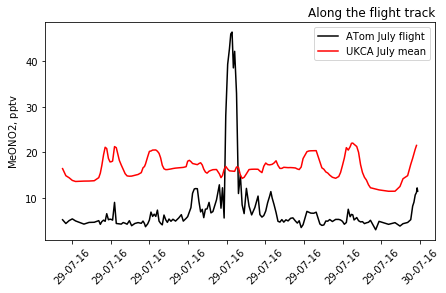

In [12]:
# Plot time series
fig, ax = plt.subplots(figsize=(7, 4), facecolor='w');
ax.plot(times, atom_dswas.MeONO2_WAS.data, color='k')
ax.plot(times, traj_cbr_meono2[0,:].data*coeff_meono2, color='r');

# common
ax.set_xticklabels(times, rotation=45);
ax.xaxis.set_major_formatter(formatter)
ax.set_title('Along the flight track', loc='right');
ax.set_ylabel('$MeONO2$, pptv');
ax.legend(['ATom July flight', 'UKCA July mean']);

# .ict
# ax.plot(times[t0:t1], atom['MeONO2_WAS'][t0:t1], color='k') 
# ax.plot(times[t0:t1], traj_cbr_meono2[0,:].data*coeff_meono2, color='r');
# ax.set_xticklabels(times[t0:t1], rotation=45);

#### Vertical profile along flight track

In [13]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_mod_bin_inds = np.arange(0, len(alt_bins), 1)
alt_obs_bin_inds = np.digitize(atom_dsmms.G_ALT.data, alt_bins)
# Convert xarray dataset with observational data to pandas dataframe
atom_pdwas_meono2 = atom_dswas.MeONO2_WAS.to_dataframe()
# Bin observational data
obs_meono2_bin_mean = atom_pdwas_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_min = atom_pdwas_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_max = atom_pdwas_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
# Convert iris cube with model data to pandas dataframe
traj_cbr2pd_meono2 = traj_cbr_meono2.copy()
traj_cbr2pd_meono2.remove_coord('t')
traj_cbr2pd_meono2.remove_coord('longitude')
traj_cbr2pd_meono2.remove_coord('latitude')
traj_pd_meono2 = iris.pandas.as_data_frame(traj_cbr2pd_meono2).T
# Bin model data
mod_meono2_bin_mean = traj_pd_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
mod_meono2_bin_min = traj_pd_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
mod_meono2_bin_max = traj_pd_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)

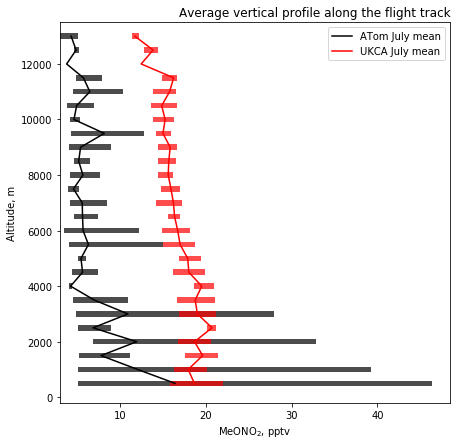

In [20]:
# Plot vertical profile along flight track
fig, ax = plt.subplots(figsize=(7, 7), facecolor='w')
ax.plot(obs_meono2_bin_mean, alt_bins, color='k');
ax.barh(alt_bins, obs_meono2_bin_max.MeONO2_WAS-obs_meono2_bin_min.MeONO2_WAS, left=obs_meono2_bin_min.MeONO2_WAS,
        height=200, align='center', color='k', alpha=0.7);

ax.plot(mod_meono2_bin_mean*coeff_meono2, alt_bins, color='r');
ax.barh(alt_bins, (mod_meono2_bin_max[0]-mod_meono2_bin_min[0])*coeff_meono2, left=mod_meono2_bin_min[0]*coeff_meono2, 
        height=200, align='center', color='r', alpha=0.7);

# common
ax.set_ylim(-200,13500);
ax.set_xlabel('$MeONO_2$, pptv');
ax.set_ylabel('Altitude, m');
ax.set_title('Average vertical profile along the flight track', loc='right')
ax.legend(['ATom July mean', 'UKCA July mean']);

#### Vertical profile along flight track, observation data from with .ict files

In [ ]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_mod_bin_inds = np.arange(0, len(alt_bins), 1)
alt_obs_bin_inds = np.digitize(atom.G_ALT[t0:t1], alt_bins)
# Bin observational data
obs_meono2_bin_mean = atom.MeONO2_WAS[t0:t1].groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_min = atom.MeONO2_WAS[t0:t1].groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
obs_meono2_bin_max = atom.MeONO2_WAS[t0:t1].groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
# Convert iris cube with model data to pandas dataframe
traj_cbr2pd_meono2 = traj_cbr_meono2.copy()
traj_cbr2pd_meono2.remove_coord('t')
traj_cbr2pd_meono2.remove_coord('longitude')
traj_cbr2pd_meono2.remove_coord('latitude')
traj_pd_meono2 = iris.pandas.as_data_frame(traj_cbr2pd_meono2).T
# Bin model data
mod_meono2_bin_mean = traj_pd_meono2.groupby(alt_obs_bin_inds).mean().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
mod_meono2_bin_min = traj_pd_meono2.groupby(alt_obs_bin_inds).min().reindex(index=alt_mod_bin_inds, fill_value=np.nan)
mod_meono2_bin_max = traj_pd_meono2.groupby(alt_obs_bin_inds).max().reindex(index=alt_mod_bin_inds, fill_value=np.nan)

In [ ]:
# Plot vertical profile along flight track
fig, ax = plt.subplots(figsize=(7, 7), facecolor='w')
ax.plot(obs_meono2_bin_mean, alt_bins, color='k');
ax.barh(alt_bins, obs_meono2_bin_max-obs_meono2_bin_min, left=obs_meono2_bin_min, height=200, align='center', color='k', alpha=0.7);
ax.plot(mod_meono2_bin_mean*coeff_meono2, alt_bins, color='r');
ax.barh(alt_bins, (mod_meono2_bin_max[0]-mod_meono2_bin_min[0])*coeff_meono2, left=mod_meono2_bin_min[0]*coeff_meono2, 
        height=200, align='center', color='r', alpha=0.7);
# common
ax.set_ylim(-200,13500);
ax.set_xlabel('$MeONO_2$, pptv');
ax.set_ylabel('Altitude, m');
ax.set_title('Average vertical profile along the flight track', loc='right')
ax.legend(['ATom July ??-?? mean', 'UKCA July mean']);

#### Surface concentrations and flight samples

In [ ]:
cbr_meono2.coord('altitude').points

In [24]:
t0, t1 = 0, 160

In [31]:
# atom.MeONO2_WAS[t0:t1].max()
map_lev = 4

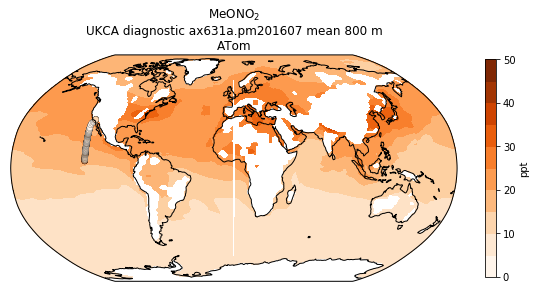

In [32]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax.coastlines();
ax.set_global();
bounds_meono2 = np.arange(0,55,5)
norm_meono2 = colors.BoundaryNorm(boundaries=bounds_meono2, ncolors=256)

ax.contourf(cbr_meono2.coord('longitude').points, cbr_meono2.coord('latitude').points, cbr_meono2[0,map_lev,...].data*coeff_meono2,
            transform=ccrs.PlateCarree(), levels=bounds_meono2, cmap='Oranges');
p1 = ax.scatter(sample_lons, sample_lats, c=atom.MeONO2_WAS[t0:t1], 
                transform=ccrs.PlateCarree(), norm=norm_meono2, cmap='Oranges', edgecolors='k', linewidth=0.2);

# common
ax.set_title('$MeONO_2$\nUKCA diagnostic ax631a.pm201607 mean {} m\nATom'.format(map_lev*200));
fig.colorbar(p1, shrink=0.4, label='ppt');

In [ ]:
# # Useful reference code
# from cf_units import Unit
# # Correct hybrid_height units from 'unknown' to 'm'
# cb_meono2.coord('Hybrid height').units = Unit('m')
# # Add surface_altitude coordinate to the cube
# new_coord = iris.coords.AuxCoord(cb_srf_alt.data, standard_name='surface_altitude', units='m')
# cb_meono2.add_aux_coord(new_coord, data_dims=[2, 3])
# # Derive altitude coordinate from surface_altitude
# factory = iris.aux_factory.HybridHeightFactory(delta=cb_meono2.coord('Hybrid height'), 
#                                                orography=cb_meono2.coord('surface_altitude'))
# cb_meono2.add_aux_factory(factory)
# # Relevel model data from hybrid_height to target levels (called here height)
# tgt_levels = np.arange(0, 14000, 100)
# height_coord = cb_meono2.coord('altitude').copy() # avoid duplication of coordinate names
# height_coord.rename('height')
# src_levels = height_coord

# cbr_meono2 = stratify.relevel(cb_meono2, src_levels, tgt_levels, axis='Hybrid height')

In [ ]:
# UKCA diagnostic (nudged) runs variable names
# field2101 O3 MASS MIXING RATIO AFTER TIMESTEP
# field2181 OH MASS MIXING RATIO AFTER TIMESTEP
# field2182 HO2 MASS MIXING RATIO AFTER TIMESTEP

# field2102 NO MASS MIXING RATIO AFTER TIMESTEP
# field2110 CO MASS MIXING RATIO AFTER TSTEP
# field2109 CH4 MASS MIXING RATIO AFTER TSTEP
# field2114 C2H6 MASS MIXING RATIO AFTER TSTEP
# field2118 C3H8 MASS MIXING RATIO AFTER TSTEP
# field2273 n-C4H10 MASS MIXING RATIO AFTER TS
# field2274 i-C4H10 MASS MIXING RATIO AFTER TS
# field2275 n-C5H12 MASS MIXING RATIO AFTER TS
# field2276 i-C5H12 MASS MIXING RATIO AFTER TS

# field2125 MeONO2 MASS MIXING RATIO AFTER TSTEP
# field2287 n-BuONO2 MASS MIXING RATIO AFTER TS
# field2288 s-BuONO2 MASS MIXING RATIO AFTER TS
# field2289 n-2PeONO2 MASS MIXING RATIO AFTER TS
# field2290 n-3PeONO2 MASS MIXING RATIO AFTER TS
# field2291 i-PeONO2 MASS MIXING RATIO AFTER TS

# field2164 IDT1 MASS MIXING RATIO AFTER TS global 5 day
# field2165 IDT2 MASS MIXING RATIO AFTER TS global 30 day
# field2165_13 IDT19 MASS MIXING RATIO AFTER TS N America 5 day
# field2165_14 IDT20 MASS MIXING RATIO AFTER TS N America 30 day
# field2165_17 IDT23 MASS MIXING RATIO AFTER TS Europe 5 day
# field2165_18 IDT24 MASS MIXING RATIO AFTER TS Europe 30 day
# field2165_19 IDT25 MASS MIXING RATIO AFTER TS N Africa 5 day
# field2165_20 IDT26 MASS MIXING RATIO AFTER TS N Africa 30 day

In [ ]:
break

#### xarray only

In [ ]:
M_air = 28.97 # dry air [kg]
O3 = ds.field2101*(M_air/48)*1e9
nC4H10 = ds.field2273*(M_air/58.1222)*1e12

In [ ]:
plt.contourf(nC4H10.isel(t=0, hybrid_ht=0));
plt.colorbar();

In [ ]:
# x = xr.DataArray([0, 2, 4], dims='z')
# y = xr.DataArray([0.1, 0.2, 0.3], dims='z')
# da.interp(x=x, y=y)
# type(O3)

In [ ]:
new = nC4H10.interp(latitude=obs_lats, longitude=obs_lons, latitude='latitude')

In [ ]:
new.shape

In [ ]:
obs_lats = atom.AMS_LAT[0:20]
obs_lons = atom.AMS_LON[0:20]+360
plt.scatter(obs_lons, obs_lats, c=atom['n-Butane_WAS'][0:20], cmap='viridis');
# plt.scatter(new.longitude, new.latitude, c=new.isel(hybrid_ht=0, t=0), cmap='viridis');

In [ ]:
plt.plot(atom['n-Butane_WAS'][0:20], color='k');
# plt.plot(new.isel(hybrid_ht=0, t=0));

#### old code

In [ ]:
CO = ds.field2110*(M_air/28.0101)*1e9
O3 = ds.field2101*(M_air/48)*1e9
# nC4H10 = cartopy.util.add_cyclic_point(ds.field2273.isel(hybrid_ht=1, t=0).values*(M_air/58.1222)*1e12)

# MeONO2 = ds.field2125*(M_air/77.0394)*1e12
# nBuONO2 = cartopy.util.add_cyclic_point(ds.field2287.isel(hybrid_ht=1, t=0).values*(M_air/119.1192)*1e12)
# sBuONO2 = cartopy.util.add_cyclic_point(ds.field2288.isel(hybrid_ht=1, t=0).values*(M_air/119.1192)*1e12)

# nPeBONO2 = cartopy.util.add_cyclic_point(ds.field2289.isel(hybrid_ht=5, t=0).values*(M_air/133.1457)*1e12) # n2PeONO2
# nPeCONO2 = cartopy.util.add_cyclic_point(ds.field2290.isel(hybrid_ht=1, t=0).values*(M_air/133.1457)*1e12) # n3PeONO2
# iPeBONO2 = cartopy.util.add_cyclic_point(ds.field2291.isel(hybrid_ht=1, t=0).values*(M_air/133.1457)*1e12) # iPeONO2

h = 2000 # [m]

In [ ]:
# ds_o3.longitude.sel(longitude=(360+x_helmig2014), method='nearest')
# ds_o3.latitude.sel(latitude=y_helmig2014, method='nearest')
# da.interp(longitude=flight_loh, latitude=flight_lat, hybrid_height=flight_hight)

In [ ]:
atom['MeONO2_WAS'][atom.G_ALT<h].max(), atom['MeONO2_WAS'].max(), MeONO2.max()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
bounds_meono2 = np.arange(0,100,10)
norm_meono2 = colors.BoundaryNorm(boundaries=bounds_meono2, ncolors=256)
p = ax.contourf(cyclic_lons, ds.latitude, MeONO2.isel(hybrid_ht=1, t=0), levels=bounds_meono2, transform=ccrs.PlateCarree());
p1 = ax.scatter(atom.G_LONG[atom.G_ALT<h], atom.G_LAT[atom.G_ALT<h], c=atom['MeONO2_WAS'][atom.G_ALT<h], 
                norm=norm_meono2, cmap='viridis', edgecolors='k', linewidth=0.2, transform=ccrs.PlateCarree());
ax.set_title('$MeONO_2$\nUKCA diagnostic 2015 annual mean level 1 (aw103a)\nATom merge 1&2 all data below 2 km');
fig.colorbar(p, shrink=0.4, label='pptv');
# fig.colorbar(p1, shrink=0.4, label='ppt');

In [ ]:
atom['2-BuONO2_WAS'][atom.G_ALT<h].max(), atom['2-BuONO2_WAS'].max(), sBuONO2.max()

In [ ]:
# plt.plot(atom['2-BuONO2_WAS'][:]); # ?

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
bounds_sbuono2 = np.arange(0,80,10)
norm_sbuono2 = colors.BoundaryNorm(boundaries=bounds_sbuono2, ncolors=256)
p = ax.contourf(cyclic_lons, ds.latitude, sBuONO2, levels=bounds_sbuono2, transform=ccrs.PlateCarree());
p1 = ax.scatter(atom.G_LONG[atom.G_ALT<h], atom.G_LAT[atom.G_ALT<h], c=atom['2-BuONO2_WAS'][atom.G_ALT<h], 
                norm=norm_sbuono2, cmap='viridis', edgecolors='k', linewidth=0.2, transform=ccrs.PlateCarree());
ax.set_title('$sBuONO_2 (2$-$BuONO2)$\nUKCA diagnostic 2015 annual mean level 1 (aw103a)\nATom merge 1&2 all data below 2 km');
fig.colorbar(p, shrink=0.4, label='pptv');
# fig.colorbar(p1, shrink=0.4, label='ppt'); 

In [ ]:
nBuONO2.max()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
p = ax.contourf(cyclic_lons, ds.latitude, nBuONO2, transform=ccrs.PlateCarree());
ax.set_title('$nBuONO_2 (1$-$BuONO2)$\nUKCA diagnostic 2015 annual mean level 1 (aw103a)\nNo ATom data');
fig.colorbar(p, shrink=0.4, label='pptv');

In [ ]:
atom['2-PenONO2_WAS'][atom.G_ALT<h].max(), atom['2-PenONO2_WAS'].max(), nPeBONO2.max()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
bounds_npebono2 = np.arange(0,11,1)
norm_npebono2 = colors.BoundaryNorm(boundaries=bounds_npebono2, ncolors=256)
p = ax.contourf(cyclic_lons, ds.latitude, nPeBONO2, levels=bounds_npebono2, transform=ccrs.PlateCarree());
p1 = ax.scatter(atom.G_LONG[atom.G_ALT<h], atom.G_LAT[atom.G_ALT<h], c=atom['2-PenONO2_WAS'][atom.G_ALT<h], 
                norm=norm_npebono2, cmap='viridis', edgecolors='k', linewidth=0.2, transform=ccrs.PlateCarree());
ax.set_title('$nPeBONO_2 (2$-$PenONO2)$\nUKCA diagnostic 2015 annual mean level 1 (aw103a)\nATom merge 1&2 all data below 2 km');
fig.colorbar(p, shrink=0.4, label='pptv');
# fig.colorbar(p1, shrink=0.4, label='ppt'); 

In [ ]:
atom['3-PenONO2_WAS'][atom.G_ALT<h].max(), atom['3-PenONO2_WAS'].max(), nPeCONO2.max()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
bounds_npecono2 = np.arange(0,45,5)
norm_npecono2 = colors.BoundaryNorm(boundaries=bounds_npecono2, ncolors=256)
p = ax.contourf(cyclic_lons, ds.latitude, nPeCONO2, levels=bounds_npecono2, transform=ccrs.PlateCarree());
p1 = ax.scatter(atom.G_LONG[atom.G_ALT<h], atom.G_LAT[atom.G_ALT<h], c=atom['3-PenONO2_WAS'][atom.G_ALT<h], 
                norm=norm_npecono2, cmap='viridis', edgecolors='k', linewidth=0.2, transform=ccrs.PlateCarree());
ax.set_title('$nPeCONO_2 (3$-$PenONO2)$\nUKCA diagnostic 2015 annual mean level 1 (aw103a)\nATom merge 1&2 all data below 2 km');
fig.colorbar(p, shrink=0.4, label='pptv');
# fig.colorbar(p1, shrink=0.4, label='ppt'); 

In [ ]:
atom['3-Methyl-2-BuONO2_WAS'][atom.G_ALT<h].max(), atom['3-Methyl-2-BuONO2_WAS'].max(), iPeBONO2.max()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
bounds_ipebono2 = np.arange(0,45,5)
norm_ipebono2 = colors.BoundaryNorm(boundaries=bounds_ipebono2, ncolors=256)
p = ax.contourf(cyclic_lons, ds.latitude, iPeBONO2, levels=bounds_ipebono2, transform=ccrs.PlateCarree());
p1 = ax.scatter(atom.G_LONG[atom.G_ALT<h], atom.G_LAT[atom.G_ALT<h], c=atom['3-Methyl-2-BuONO2_WAS'][atom.G_ALT<h], 
                norm=norm_ipebono2, cmap='viridis', edgecolors='k', linewidth=0.2, transform=ccrs.PlateCarree());
ax.set_title('$iPeBONO_2 (3$-$Methyl$-$2$-$BuONO2)$\nUKCA diagnostic 2015 annual mean level 1 (aw103a)\nATom merge 1&2 all data below 2 km');
fig.colorbar(p, shrink=0.4, label='pptv');
# fig.colorbar(p1, shrink=0.4, label='ppt'); 

In [ ]:
break

In [ ]:
atom['n-Butane_WAS'][atom.G_ALT<h].max(), atom['n-Butane_WAS'].max(), nC4H10.max()

In [ ]:
# plt.plot(atom['2-BuONO2_WAS'][:]); # ?

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
bounds_nc4h10 = np.arange(0,3000,100)
norm_nc4h10 = colors.BoundaryNorm(boundaries=bounds_nc4h10, ncolors=256)
p = ax.contourf(cyclic_lons, ds.latitude, nC4H10, levels=bounds_nc4h10, transform=ccrs.PlateCarree());
p1 = ax.scatter(atom.G_LONG[atom.G_ALT<h], atom.G_LAT[atom.G_ALT<h], c=atom['n-Butane_WAS'][atom.G_ALT<h], 
                norm=norm_nc4h10, cmap='viridis', edgecolors='k', linewidth=0.2, transform=ccrs.PlateCarree());
ax.set_title('$nC_4H_{10}$ (n$-$Butane)\nUKCA diagnostic 2015 annual mean level 1 (aw103a)\nATom merge 1&2 all data below 2 km');
fig.colorbar(p, shrink=0.4, label='pptv');
# fig.colorbar(p1, shrink=0.4, label='ppt'); 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
p = ax.contourf(cyclic_lons, ds.latitude, nPeBONO2, transform=ccrs.PlateCarree());
ax.set_title('$nPeBONO_2$ aw103a 2015 annual mean, level 1');
fig.colorbar(p, shrink=0.4, label='ppt');

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
p = ax.contourf(cyclic_lons, ds.latitude, iPeBONO2, transform=ccrs.PlateCarree());
ax.set_title('$iPeBONO_2$ aw103a 2015 annual mean, level 1');
fig.colorbar(p, shrink=0.4, label='ppt');

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)), facecolor='w')
ax.coastlines();
p = ax.contourf(cyclic_lons, ds.latitude, CO, levels=np.arange(0, 110, 10), transform=ccrs.PlateCarree());
ax.set_title('CO\nUKCA diagnostic 2015 annual mean level 1 (aw103a)');
fig.colorbar(p, shrink=0.4, label='ppb');

In [ ]:
90/70

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 30), facecolor='w',
#                        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0, globe=None)))
# p0 = ax[0].contourf(cyclic_lons, ds.latitude, nBuONO2, transform=ccrs.PlateCarree());
# p1 = ax[1].contourf(cyclic_lons, ds.latitude, sBuONO2, transform=ccrs.PlateCarree());
# ax[0].set_title('$nBuONO_2$ aw103a 2015 annual mean, level 1');
# ax[1].set_title('$sBuONO_2$ aw103a 2015 annual mean, level 1');
# fig.colorbar(p0, shrink=0.1, label='pptv', ax=ax[0]);
# fig.colorbar(p1, shrink=0.1, label='pptv', ax=ax[1]);
# # common
# ax[0].coastlines();
# ax[1].coastlines();